# Boxplot of top five up- and downregulated genes

In [1]:
library(ggpubr)
library(ggsignif)
library(tidyverse)

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Functions

In [2]:
add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
    as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
    dplyr::ungroup() %>%
    mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}

save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## Genes

### Differential expressed genes

In [3]:
drd2 = read.delim('../../_m/genes/diffExpr_maleVfemale_full.txt') %>%
    filter(Symbol == 'DRD2') %>% 
    select(gencodeID, ensemblID, Symbol, logFC, t, adj.P.Val) %>%
    add_symnum() %>% mutate_if(is.character, as.factor)
drd2 %>% head(2)

,gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,ENSG00000149295.13,ENSG00000149295,DRD2,0.06437243,1.806703,0.4299049,0.43,ns


### Load residualized expression

In [4]:
res_file = '../../_m/genes/residualized_expression.tsv'
resdf0 = data.table::fread(res_file) %>% 
    filter(V1 %in% drd2$gencodeID) %>% column_to_rownames("V1") %>%
    t %>% data.frame
resdf0 %>% head(2)

Warning message in data.table::fread(res_file):
“Detected 393 column names but the data has 394 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,ENSG00000149295.13
,<dbl>
R12864,-1.903295
R12865,1.520050


### Load pheno data

In [5]:
pheno_file = '/ceph/users/jbenja13/projects/sex_sz_ria/input/phenotypes/_m/phenotypes.csv'
pheno = read.csv(pheno_file) %>% 
    mutate_if(is.character, as.factor) %>% 
    column_to_rownames("RNum") %>% 
    filter(Region=="Caudate") %>%
    select(Sex, Dx, Age, Region, BrNum)
levels(pheno$Sex) <- c("Female", "Male")
head(pheno, 2)

,Sex,Dx,Age,Region,BrNum
,<fct>,<fct>,<dbl>,<fct>,<fct>
R12864,Female,Schizo,42.98,Caudate,Br1303
R12865,Male,Schizo,53.12,Caudate,Br1320


### Merge dataframe

In [6]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf %>% head(2)

[1] 393   7

,rowname,Sex,Dx,Age,Region,BrNum,ENSG00000149295.13
,<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
1,R12864,Female,Schizo,42.98,Caudate,Br1303,-1.903295
2,R12865,Male,Schizo,53.12,Caudate,Br1320,1.520050


### Melt data frame

In [7]:
df = resdf %>% select(c('rowname', 'Sex', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Sex), names_to = "gencodeID", values_to = "Res") %>%
    inner_join(drd2, by='gencodeID') %>% 
    mutate_at(vars("Symbol", "gencodeID"), as.factor)

df$Symbol = with(df, reorder(Symbol, adj.P.Val, median))
head(df, 2)

rowname,Sex,gencodeID,Res,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif
<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
R12864,Female,ENSG00000149295.13,-1.903295,ENSG00000149295,DRD2,0.06437243,1.806703,0.4299049,0.43,ns
R12865,Male,ENSG00000149295.13,1.520050,ENSG00000149295,DRD2,0.06437243,1.806703,0.4299049,0.43,ns


### Initial ggplot with ggpubr

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


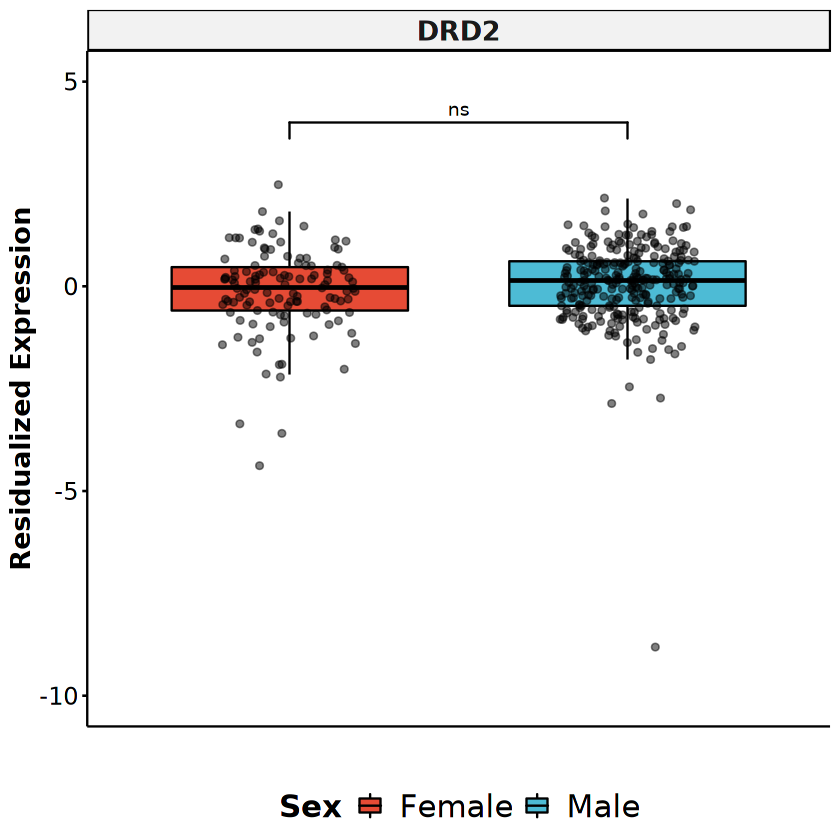

In [8]:
tmp = drd2 %>% mutate(group1='Female', group2='Male', y_pos=4) %>% 
    mutate_if(is.character, as.factor)

bxp_g <- ggboxplot(df, x="Sex", y="Res", facet.by=c("Symbol"), fill="Sex", xlab='', 
                 panel.labs.font=list(face='bold', size = 16), palette="npg", 
                 outlier.shape=NA, ylab='Residualized Expression', add='jitter', 
                 ylim=c(-10, 5), add.params=list(alpha=0.5), legend="bottom",
                 ggtheme=theme_pubr()) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                manual=TRUE) + 
    font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
    font("legend.title", size=18, face="bold") + 
    font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_g

## Junction

### Differential expressed genes

In [9]:
drd2 = data.table::fread('../../_m/junctions/diffExpr_maleVfemale_full.txt') %>%
    filter(Symbol == 'DRD2') %>% 
    select(V1, gencodeGeneID, ensemblID, Symbol, logFC, t, adj.P.Val) %>%
    rename("gencodeID"="gencodeGeneID", "Feature"="V1") %>% add_symnum() 
drd2 %>% head(2)

Feature,gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr11:113418137-113424366(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.08942243,1.524020,0.7726092,0.77,ns
chr11:113414462-113415420(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.08731921,1.355108,0.8083077,0.81,ns


### Load residualized expression

In [10]:
res_file = '../../_m/junctions/residualized_expression.tsv'
resdf0 = data.table::fread(res_file) %>% 
    inner_join(drd2, by=c("V1"="Feature")) %>% 
    mutate(ID=paste0("j",1:dim(drd2)[1])) %>% 
    column_to_rownames("ID") %>% select(starts_with("R")) %>%
    t %>% data.frame
resdf0 %>% head(2)
jxn_ann = data.table::fread(res_file) %>% 
    inner_join(drd2, by=c("V1"="Feature")) %>% 
    mutate(ID=paste0("j",1:dim(drd2)[1])) %>% 
    select(!starts_with("R")) 
jxn_ann %>% head(2)

Warning message in data.table::fread(res_file):
“Detected 393 column names but the data has 394 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,j1,j2,j3,j4,j5,j6,j7,j8,j9,j10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R12864,-0.8127860,-0.6714232,-0.1656533,-0.8511028,-0.7196601,-0.6241724,-0.4327616,-0.33900952,-0.834775255,0.3094873
R12865,0.3310892,-0.6067889,-1.1151507,0.2102291,0.3115348,0.3511729,-0.2597435,0.03867515,-0.001217162,-3.5606112


Warning message in data.table::fread(res_file):
“Detected 393 column names but the data has 394 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


V1,gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,ID
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr11:113410921-113412555(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.07738113,1.198093,0.8390205,0.84,ns,j1
chr11:113412884-113414374(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.08167665,1.262510,0.8258819,0.83,ns,j2


### Load pheno data

In [11]:
pheno_file = '/ceph/users/jbenja13/projects/sex_sz_ria/input/phenotypes/_m/phenotypes.csv'
pheno = read.csv(pheno_file) %>% 
    mutate_if(is.character, as.factor) %>% 
    column_to_rownames("RNum") %>% 
    filter(Region=="Caudate") %>%
    select(Sex, Dx, Age, Region, BrNum)
levels(pheno$Sex) <- c("Female", "Male")
head(pheno, 2)

,Sex,Dx,Age,Region,BrNum
,<fct>,<fct>,<dbl>,<fct>,<fct>
R12864,Female,Schizo,42.98,Caudate,Br1303
R12865,Male,Schizo,53.12,Caudate,Br1320


### Merge dataframe

In [12]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf %>% head(2)

[1] 393  16

,rowname,Sex,Dx,Age,Region,BrNum,j1,j2,j3,j4,j5,j6,j7,j8,j9,j10
,<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R12864,Female,Schizo,42.98,Caudate,Br1303,-0.8127860,-0.6714232,-0.1656533,-0.8511028,-0.7196601,-0.6241724,-0.4327616,-0.33900952,-0.834775255,0.3094873
2,R12865,Male,Schizo,53.12,Caudate,Br1320,0.3310892,-0.6067889,-1.1151507,0.2102291,0.3115348,0.3511729,-0.2597435,0.03867515,-0.001217162,-3.5606112


### Melt data frame

In [13]:
df = resdf %>% select(c('rowname', 'Sex', starts_with('j'))) %>%
    pivot_longer(-c(rowname, Sex), names_to = "ID", values_to = "Res") %>%
    inner_join(jxn_ann, by="ID") %>% mutate(New_ID=paste(Symbol, V1, sep='\n')) %>%
    mutate_at(vars("Symbol", "New_ID"), as.factor)
df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
df %>% head(2)

rowname,Sex,ID,Res,V1,gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,New_ID
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
R12864,Female,j1,-0.8127860,chr11:113410921-113412555(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.07738113,1.198093,0.8390205,0.84,ns,DRD2 chr11:113410921-113412555(-)
R12864,Female,j2,-0.6714232,chr11:113412884-113414374(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.08167665,1.262510,0.8258819,0.83,ns,DRD2 chr11:113412884-113414374(-)


### Initial ggplot with ggpubr

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


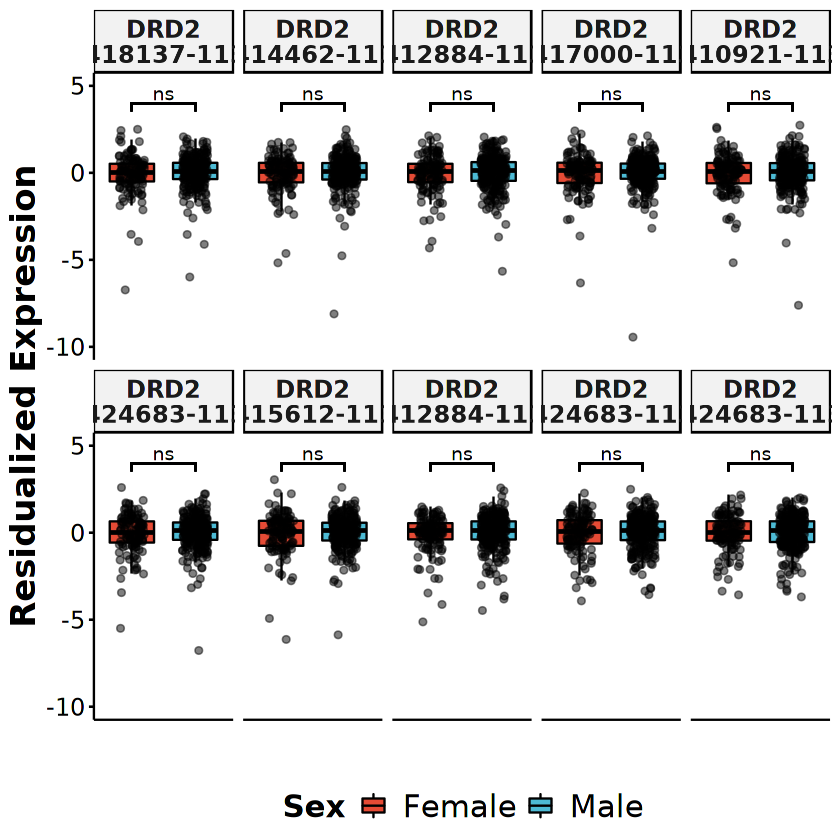

In [14]:
tmp = drd2 %>% mutate(group1='Female', group2='Male', y_pos=4) %>% 
    mutate_if(is.character, as.factor)

bxp_j <- ggboxplot(df, x="Sex", y="Res", facet.by=c("New_ID"), fill="Sex", xlab='', 
                 panel.labs.font=list(face='bold', size = 14), palette="npg", 
                 outlier.shape=NA, ylab='Residualized Expression', add='jitter', 
                 ylim=c(-10, 5), add.params=list(alpha=0.5), legend="bottom",
                 ggtheme=theme_pubr(), ncol=5) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                manual=TRUE) + 
    font("xy.title", size=20, face="bold") + font("xy.text", size=14) +
    font("legend.title", size=18, face="bold") + 
    font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_j

### Annotate figure

In [15]:
save_ggplots('drd2_gene', bxp_g, 6, 6)
save_ggplots('drd2_junctions', bxp_j, 16, 10)

## Session Info

In [16]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-07-10 10:20:31 EDT"

   user  system elapsed 
 25.141  25.926  27.737 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-10                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 Cairo         1.5-12.2 2020-07-07 [1] CRAN (R 